## Installation
A tiny Autograd engine (with a bite! :)). Implements backpropagation (reverse-mode autodiff) over a dynamically built DAG and a small neural networks library on top of it with a PyTorch-like API. Both are tiny, with about 100 and 50 lines of code respectively. The DAG only operates over scalar values, so e.g. we chop up each neuron into all of its individual tiny adds and multiplies. However, this is enough to build up entire deep neural nets doing binary classification, as the demo notebook shows. Potentially useful for educational purposes

In [5]:
pip install micrograd

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Example usage
Below is a slightly contrived example showing a number of possible supported operations:

In [1]:
### Source : https://github.com/karpathy/micrograd
from micrograd.engine import Value

a = Value(-2.0)
b = Value(3.0)
c = a + b
d = a * b + b**3
c += c + 1
c += 1 + c + (-a)
d += d * 1.5 + (b + a).relu()
d += 3 * d + (b - a).relu()
e = c - d
f = e**2
g = f / 3.0
g += 10.0 / f


Below (g.backward())  initialize back propagation at the node g and what backpropagation is going to do is it's going to start at g and it's going to go backwards through that expression, to evaluate the derivative of g with respect to all the internal nodes like e d and c but also with respect to the inputs a and b and then we can actually query this derivative of g with respect to a for example that's a dot grad.

In [2]:
print(f'{g.data:.4f}') # prints 14700.0002, the outcome of this forward pass
g.backward()
print(f'{a.grad:.4f}') # prints 4199.9999, i.e. the numerical value of dg/da
print(f'{b.grad:.4f}') # prints 35139.9995, i.e. the numerical value of dg/db

14700.0002
4199.9999
35139.9995


# MicroGrad demo
This code below provides a full demo of training an 2-layer neural network (MLP) binary classifier. This is achieved by initializing a neural net from micrograd.nn module, implementing a simple svm "max-margin" binary classification loss and using SGD for optimization. As shown in the notebook, using a 2-layer neural net with two 16-node hidden layers we achieve the following decision boundary on the moon dataset:

Import libraries

In [8]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

In [10]:
np.random.seed(1967)
random.seed(1971)

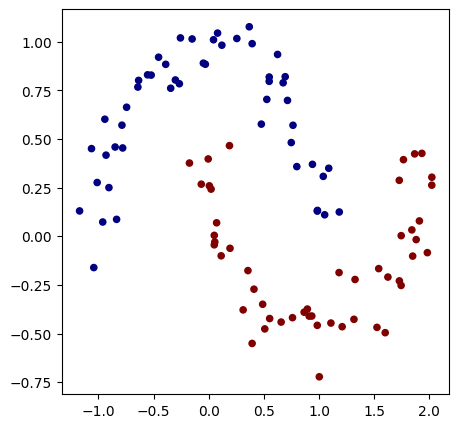

In [11]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [12]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [13]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=1.088480263377706, grad=0) 0.5


In [15]:
# optimization
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 1.088480263377706, accuracy 50.0%
step 1 loss 2.5881132803589595, accuracy 50.0%
step 2 loss 1.5641818777424443, accuracy 50.0%
step 3 loss 0.4516708109726059, accuracy 79.0%
step 4 loss 0.39482183155122674, accuracy 81.0%
step 5 loss 0.36937722603402856, accuracy 82.0%
step 6 loss 0.3429156270425065, accuracy 85.0%
step 7 loss 0.3180121038344879, accuracy 88.0%
step 8 loss 0.29432521315500176, accuracy 88.0%
step 9 loss 0.26826481845939787, accuracy 90.0%
step 10 loss 0.2478241247152248, accuracy 90.0%
step 11 loss 0.21167804859288103, accuracy 94.0%
step 12 loss 0.20768672350453507, accuracy 93.0%
step 13 loss 0.2529180331053035, accuracy 93.0%
step 14 loss 0.40639821828661704, accuracy 88.0%
step 15 loss 0.15106657300129814, accuracy 94.0%
step 16 loss 0.127878889710687, accuracy 96.0%
step 17 loss 0.11885914608086018, accuracy 95.0%
step 18 loss 0.09728804164341592, accuracy 99.0%
step 19 loss 0.08508719759430859, accuracy 97.0%
step 20 loss 0.08243947458408413, accurac

(-1.7223026132145343, 2.0276973867854657)

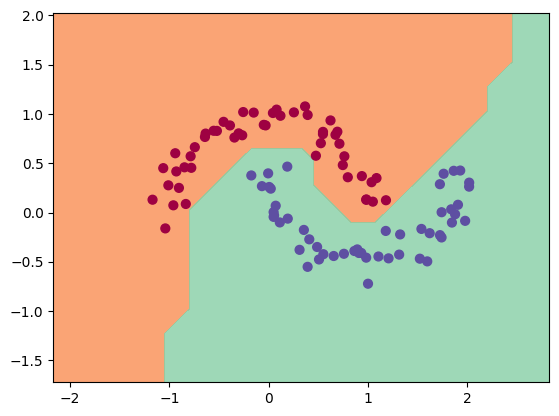

In [16]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())